In [6]:
import av
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Tuple, List
from scipy.fftpack import dct, idct
import math
import numba
from concurrent.futures import ThreadPoolExecutor
local_search = False
def dct2d(block: np.ndarray) -> np.ndarray:
    """
    Двумерное ДКП
    """
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct2d(block: np.ndarray) -> np.ndarray:
    """
    Обратное двумерное ДКП
    """
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

@numba.jit(nopython=True)
def calc_Q_block(size_block: int, Rquant: int):
        Q_matrix = np.zeros((size_block, size_block))
        for i in range(0, size_block):
            for j in range(0, size_block):
                Q_matrix[i][j] = 1 + (i + j) * Rquant
        return Q_matrix

@numba.jit(nopython=True)
def quantize(block: np.ndarray, Rquant: int, size_block: int = 8):
    Q_block = calc_Q_block(size_block, Rquant)
    res = np.zeros((size_block, size_block))
    for i in range(0, size_block):
        for j in range(0, size_block):
            res[i][j] = round(block[i][j] / Q_block[i][j])
    return res

@numba.jit(nopython=True)
def dequantize(block: np.ndarray, Rquant: int, size_block: int = 8):
    Q_block = calc_Q_block(size_block, Rquant)
    res = np.zeros((size_block, size_block))
    for i in range(0, size_block):
        for j in range(0, size_block):
            res[i][j] = block[i][j] * Q_block[i][j]
    return res

@numba.jit(nopython=True)
def logarithmic_search(curr_block: np.ndarray, 
                    reference_frame: np.ndarray, 
                    x: int, 
                    y: int, 
                    search_radius: int = 8) -> Tuple[int, int]:
    """
    Реализация алгоритма логарифмического поиска для оценки движения
    """
    block_size = curr_block.shape[0]
    best_x, best_y = x, y
    best_sad = float('inf')
    step = search_radius // 2

    while step >= 1:
        for dx in [-step, 0, step]:
            for dy in [-step, 0, step]:
                new_x = x + dx
                new_y = y + dy
                
                if (new_x < 0 or new_x + block_size > reference_frame.shape[0] or
                    new_y < 0 or new_y + block_size > reference_frame.shape[1]):
                    continue
                
                reference_block = reference_frame[new_x:new_x+block_size, 
                                            new_y:new_y+block_size]
                
                sad = np.sum(np.abs(curr_block - reference_block))
                
                if sad < best_sad:
                    best_sad = sad
                    best_x = new_x
                    best_y = new_y
        
        step //= 2
    
    return best_x - x, best_y - y

def compute_motion_compensated_frame(current: np.ndarray, 
                                reference: np.ndarray,
                                block_size: int = 8,
                                search_radius: int = 8,
                                Rquant: int = 1,
                                need_diff_frame: bool = True,
                                ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, int]:
    """
    Вычисление разностного кадра с компенсацией движения и его обработка
    """
    height, width = current.shape
    diff_frame = np.zeros_like(current, dtype=np.int64)
    reconstructed_frame = np.zeros_like(current, dtype=np.uint8)
    quantized_frame = np.zeros_like(current, dtype=np.int64)
    
    for i in range(0, height - block_size + 1, block_size):
        for j in range(0, width - block_size + 1, block_size):
            curr_block = current[i:i+block_size, j:j+block_size]
            
            dx, dy = logarithmic_search(curr_block, reference, i, j, search_radius=search_radius)
            
            # Компенсация движения
            reference_block = reference[i+dx:i+dx+block_size, j+dy:j+dy+block_size]
            # predicted_frame[i:i+block_size, j:j+block_size] = reference_block
            
            # Вычисление разностного блока
            diff_block = curr_block.astype(np.int64) - reference_block.astype(np.int64)

            # ДКП разностного блока
            dct_diff_block = dct2d(diff_block)

            # Сохранение разностного блока (ДЛЯ ДЕБАГА)
            if need_diff_frame:
                diff_frame[i:i+block_size, j:j+block_size] = diff_block
            
            # Квантование ДКП коэффициентов разностного блока
            quantized_dct_diff = quantize(dct_diff_block, Rquant, block_size)
            
            # Aboba saver
            quantized_frame[i:i+block_size, j:j+block_size] = quantized_dct_diff
            
            # Деквантование
            dequantized_dct_diff = dequantize(quantized_dct_diff, Rquant, block_size)

            # Обратное ДКП 
            reconstructed_diff = idct2d(dequantized_dct_diff)


            
            
            # Восстановление блока
            reconstructed_block = np.clip(reference_block.astype(np.int64) + 
                                    reconstructed_diff, 0, 255).astype(np.uint8)
            reconstructed_frame[i:i+block_size, j:j+block_size] = reconstructed_block
            
            # Оценка размера
    compressed_size = calculate_entropy(quantized_frame)  # Энтропия для коэффициентов ДКП
    # print(quantized_frame)
    # print("Compressed size:", compressed_size)
    # print()
    return diff_frame, reconstructed_frame, compressed_size

def run_length_encode(arr):
    """Run-length encodes the array, handling potential float64 values."""
    encoded = []
    count = 1
    prev = None
    for item in arr:
        item_int = int(round(item))
        if item_int == prev:
            count += 1
        else:
            if prev is not None:
                encoded.append((count, prev))
            count = 1
            prev = item_int
    encoded.append((count, prev))
    return encoded

@numba.jit(nopython=True)
def calculate_entropy(data: np.ndarray) -> float:
    """
    Calculates entropy based on pixel value probabilities, similar to the C++ implementation.
    """
    freq = np.zeros(256)
    total_pixels = data.size

    for pixel in data.flatten():
        if pixel < 0:
            freq[0] += 1
        elif pixel > 255:
            freq[255] += 1
        else:
            freq[int(pixel)] += 1

    probabilities = freq / total_pixels
    entropy = 0
    for p in probabilities:
        if p > 0:  # Avoid log(0) error
            entropy += p * math.log2(p)

    return -entropy

def process_video(input_path: str, output_diff_path: str, output_recon_path: str, 
                Rquant: int = 1, need_diff_frame: bool = True) -> Tuple[float, float]:
    """
    Обработка видео с сохранением разностных и восстановленных кадров
    """
    container = av.open(input_path)
    recon_container = av.open(output_recon_path, mode='w')
    recon_stream = recon_container.add_stream('mpeg4',
                                            rate=container.streams.video[0].codec_context.rate)
    streams = [recon_stream]
    if need_diff_frame:
        diff_container = av.open(output_diff_path, mode='w')
        diff_stream = diff_container.add_stream('mpeg4', 
                                        rate=container.streams.video[0].codec_context.rate)
        streams.append(diff_stream)
    
    
    
    for stream in streams:
        stream.width = container.streams.video[0].width
        stream.height = container.streams.video[0].height
        stream.pix_fmt = 'yuv420p'
    
    original_frames = []
    reconstructed_frames = []
    previous_frame = None
    total_original_entropy = 0
    total_compressed_size = 0
    
    for frame in container.decode(video=0):
        img = frame.to_ndarray(format='yuv420p')
        y_component = img[:recon_stream.height, :recon_stream.width].astype(np.uint8)
        
        frame_original_entropy = calculate_entropy(y_component)
        total_original_entropy += frame_original_entropy
        
        if previous_frame is None:
            diff_frame = np.zeros_like(y_component)
            reconstructed_frame = y_component.copy()
            compressed_size = 0
        else:
            diff_frame, reconstructed_frame, compressed_size = compute_motion_compensated_frame(
                y_component, previous_frame, Rquant=Rquant, need_diff_frame=need_diff_frame)
        
        if need_diff_frame:
            diff_frame_vis = np.clip(diff_frame + 128, 0, 255).astype(np.uint8)

            diff_out_frame = av.VideoFrame.from_ndarray(diff_frame_vis, format='gray')
            packet = diff_stream.encode(diff_out_frame)
            diff_container.mux(packet)

        recon_out_frame = av.VideoFrame.from_ndarray(reconstructed_frame, format='gray')
        packet = recon_stream.encode(recon_out_frame)
        recon_container.mux(packet)
        
        original_frames.append(y_component)
        reconstructed_frames.append(reconstructed_frame)
        previous_frame = y_component
        
        total_compressed_size += compressed_size
    
    for packet_tmp in recon_stream.encode():
        recon_container.mux(packet_tmp)
    recon_container.close()
    
    if need_diff_frame:
        for packet_tmp in diff_stream.encode():
            diff_container.mux(packet_tmp)
        diff_container.close()
    
    container.close()
    
    psnrs_array = [calculate_psnr(original_frames[i], reconstructed_frames[i]) 
                        for i in range(len(original_frames))]
    psnrs_array = [psnr for psnr in psnrs_array if not np.isinf(psnr)]
    print(f"psnrs_array: {psnrs_array}")
    avg_psnr = np.mean(psnrs_array)
    compression_ratio = total_original_entropy / total_compressed_size
    
    return avg_psnr, compression_ratio


def calculate_psnr(original_frame: np.ndarray, recovered_frame: np.ndarray) -> float:
    """
    Calculate the PSNR for a single original and recovered frame.

    :param original_frame: Original frame (np.ndarray).
    :param recovered_frame: Recovered frame (np.ndarray).
    :return: PSNR value for the frame.
    """
    if original_frame.shape != recovered_frame.shape:
        raise ValueError("Original and recovered frames must have the same dimensions.")
    
    mse = np.mean((original_frame - recovered_frame) ** 2)
    
    if mse == 0:
        return float('inf')
    
    max_pixel = 255.0
    psnr = 10 * math.log10((max_pixel ** 2) / mse)
    
    return psnr

def plot_metrics(q_steps: List[int], 
                psnr_values: List[float], 
                compression_ratios: List[float]):
    """
    Построение графиков метрик
    """
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.plot(q_steps, psnr_values)
    plt.xlabel('Шаг квантования (Q)')
    plt.ylabel('PSNR (dB)')
    plt.title('PSNR vs Q')
    
    plt.subplot(132)
    plt.plot(q_steps, compression_ratios)
    plt.xlabel('Шаг квантования (Q)')
    plt.ylabel('Степень сжатия')
    plt.title('Compression Ratio vs Q')
    
    plt.subplot(133)
    plt.plot(psnr_values, compression_ratios)
    plt.xlabel('PSNR (dB)')
    plt.ylabel('Степень сжатия')
    plt.title('Compression Ratio vs PSNR')
    
    plt.tight_layout()
    plt.show()

def plot_metrics_multiple(data: Dict[str, Dict[str, List[float]]]):
    plt.figure(figsize=(15, 5))

    plt.subplot(131)
    for video_name, metrics in data.items():
        plt.plot(metrics["q_steps"], metrics["psnr_values"], label=video_name)
    plt.xlabel('Шаг квантования (Q)')
    plt.ylabel('PSNR (dB)')
    plt.title('PSNR vs Q')
    plt.legend()

    plt.subplot(132)
    for video_name, metrics in data.items():
        plt.plot(metrics["q_steps"], metrics["compression_ratios"], label=video_name)
    plt.xlabel('Шаг квантования (Q)')
    plt.ylabel('Степень сжатия')
    plt.title('Compression Ratio vs Q')
    plt.legend()

    plt.subplot(133)
    for video_name, metrics in data.items():
        plt.plot(metrics["psnr_values"], metrics["compression_ratios"], label=video_name)
    plt.xlabel('PSNR (dB)')
    plt.ylabel('Степень сжатия')
    plt.title('Compression Ratio vs PSNR')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


def process_videos(input_paths: List[str], Rquant_steps: List[int]):
    results = {}

    def process_rquant(input_path: str, Rquant: int, need_diff_frame: bool = True) -> Tuple[int, Tuple[float, float]]:
        video_name = input_path.split('/')[-1]
        psnr, ratio = process_video(
            input_path,
            f'results/{video_name}_diff.avi',
            f'results/{video_name}_recon_q{Rquant}.avi',
            Rquant,
            need_diff_frame,
        )
        return Rquant, (psnr, ratio)

    def process_single_video(input_path: str):
        video_name = input_path.split('/')[-1]
        psnr_values = []
        compression_ratios = []

        with ThreadPoolExecutor() as executor:
            futures = {}
            for i, Rquant in enumerate(Rquant_steps):
                need_diff_frame = (i == 0)
                futures[executor.submit(process_rquant, input_path, Rquant, need_diff_frame)] = Rquant
            
            for future in futures:
                Rquant, (psnr, ratio) = future.result()
                psnr_values.append(psnr)
                compression_ratios.append(ratio)

        sorted_results = sorted(zip(Rquant_steps, psnr_values, compression_ratios), key=lambda x: x[0])
        _, psnr_values, compression_ratios = zip(*sorted_results)

        return video_name, {
            "q_steps": Rquant_steps,
            "psnr_values": list(psnr_values),
            "compression_ratios": list(compression_ratios)
        }

    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(process_single_video, path): path for path in input_paths}
        for future in futures:
            video_name, result = future.result()
            results[video_name] = result

    return results

def jpeg_compress(frame: np.ndarray, Rquant: int, block_size: int = 8) -> np.ndarray:
    """
    JPEG-подобное сжатие одного кадра.
    """
    height, width = frame.shape
    quantized_frame = np.zeros_like(frame, dtype=float)

    for i in range(0, height - block_size + 1, block_size):
        for j in range(0, width - block_size + 1, block_size):
            block = frame[i:i+block_size, j:j+block_size].astype(np.float64)
            dct_block = dct2d(block)
            quantized_block = quantize(dct_block, Rquant, block_size)
            quantized_frame[i:i+block_size, j:j+block_size] = quantized_block
    return quantized_frame

def jpeg_diff(input_path: str, r_quants: list[int]) -> Dict[int, float]:
    """
    Вычисляет отношение энтропии исходного кадра к энтропии 
    после JPEG-сжатия для каждого уровня квантования.
    Возвращает словарь, где ключи - уровни квантования, 
    а значения - отношения энтропий.
    """
    container = av.open(input_path)

    original_frames = []
    for frame in container.decode(video=0):
        img = frame.to_ndarray(format='yuv420p')
        y_component = img[:container.streams.video[0].height, :container.streams.video[0].width].astype(np.uint8)
        original_frames.append(y_component)

    total_original_entropy = 0
    for frame in original_frames:
        total_original_entropy += calculate_entropy(frame)

    results = {}
    for Rquant in r_quants:
        total_jpeg_entropy = 0
        for frame in original_frames:
            jpeg_frame = jpeg_compress(frame, Rquant)
            total_jpeg_entropy += calculate_entropy(jpeg_frame)

        k = total_original_entropy / total_jpeg_entropy if total_jpeg_entropy != 0 else float("inf")
        results[Rquant] = k

    container.close()
    return results

def plot_jpeg_diff(my_algo_results: Dict[str, Dict[int, float]], jpeg_diff_results: Dict[str, Dict[int, float]]):
    """
    Displays the entropy ratio graph for different quantization levels, comparing your algorithm with JPEG.
    """
    plt.figure(figsize=(8, 6))

    for video_name in my_algo_results:
        data = my_algo_results[video_name]
        rquants = sorted(data.keys())
        k_values = [data[r] for r in rquants]
        plt.plot(rquants, k_values, label=f"{video_name} (My Algorithm)", linestyle='-')

        if video_name in jpeg_diff_results:
            data_jpeg = jpeg_diff_results[video_name]
            rquants_jpeg = sorted(data_jpeg.keys())
            k_values_jpeg = [data_jpeg[r] for r in rquants_jpeg]
            plt.plot(rquants_jpeg, k_values_jpeg, label=f"{video_name} (JPEG)", linestyle='--')


    plt.xlabel('Уровень квантования')
    plt.ylabel('Отношение энтропий (оригинал/сжатый)')
    plt.title('Сравнение алгоритмов сжатия: Отношение энтропий vs. Уровень квантования')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_metrics_multiple_step_searches(datas: List[Dict[str, List[float]]], labels: List[str]):
    """
    Построение графиков для нескольких search_step
    :param datas: список словарей, содержащих 'psnr_values', 'compression_ratios', 'q_steps'
    :param labels: список меток для каждой серии данных
    """
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    for data, label in zip(datas, labels):
        plt.plot(data["q_steps"], data["psnr_values"], label=label)
    plt.xlabel('Шаг квантования (Q)')
    plt.ylabel('PSNR (dB)')
    plt.title('PSNR vs Q')
    plt.legend()
    
    plt.subplot(132)
    for data, label in zip(datas, labels):
        plt.plot(data["q_steps"], data["compression_ratios"], label=label)
    plt.xlabel('Шаг квантования (Q)')
    plt.ylabel('Степень сжатия')
    plt.title('Compression Ratio vs Q')
    plt.legend()
    
    plt.subplot(133)
    for data, label in zip(datas, labels):
        plt.plot(data["psnr_values"], data["compression_ratios"], label=label)
    plt.xlabel('PSNR (dB)')
    plt.ylabel('Степень сжатия')
    plt.title('Compression Ratio vs PSNR')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def multiple_video_main():
    input_paths = ['lr1_1.avi', 'lr1_2.avi', 'lr1_3.avi']
    # input_paths = ['lr1_3.avi']
    # input_paths = ['lr1_2.avi']
    Rquant_steps = [0, 2, 4, 6, 8, 10]
    data = process_videos(input_paths, Rquant_steps)

    plot_metrics_multiple(data)
    
    my_algo_results = {}
    for video_name, metrics in data.items():
        my_algo_results[video_name] = {}
        for i, q_step in enumerate(metrics["q_steps"]):
            my_algo_results[video_name][q_step] = metrics["compression_ratios"][i]
    
    jpeg_diff_results = {}
    for path in input_paths:
        video_name = path.split('/')[-1]
        jpeg_diff_results[video_name] = jpeg_diff(path, Rquant_steps)

    plot_jpeg_diff(my_algo_results, jpeg_diff_results)

psnrs_array: [37.70641149857296, 37.85009709670782, 37.91513744415714, 37.88397657812548, 37.703610417973685, 37.604830529881305, 37.40049729560038, 37.467990060708885, 37.79881335359026, 38.062133696916895, 38.82897640522919, 39.17713281415741, 39.41822067569521, 39.431496388302534, 39.695368859546456, 39.565554342475465, 39.50000524177995, 39.58879304661326, 39.43006783820564, 39.51635481221309, 39.815333880307634, 40.201748957485115, 40.64063254310092, 40.57169430929319, 40.2666557292202, 39.74871734054577, 39.54206934450576, 39.71634379574378, 39.73453397284742, 39.10538214086042, 39.30433485148043, 39.768467805751044, 40.260859109023734, 40.609127357150484, 40.93428579141569, 40.91678275005861, 40.41833819875856, 40.02582766916973, 40.06385006666345, 39.82248464711067, 39.55839980140948, 39.633277593432396, 39.73770333231838, 39.59167066509567, 39.31218230630655, 39.26645720732235, 39.21611012539752, 39.17567435166573, 39.04712136277961, 38.908585875247404, 38.87294500046567, 38.8

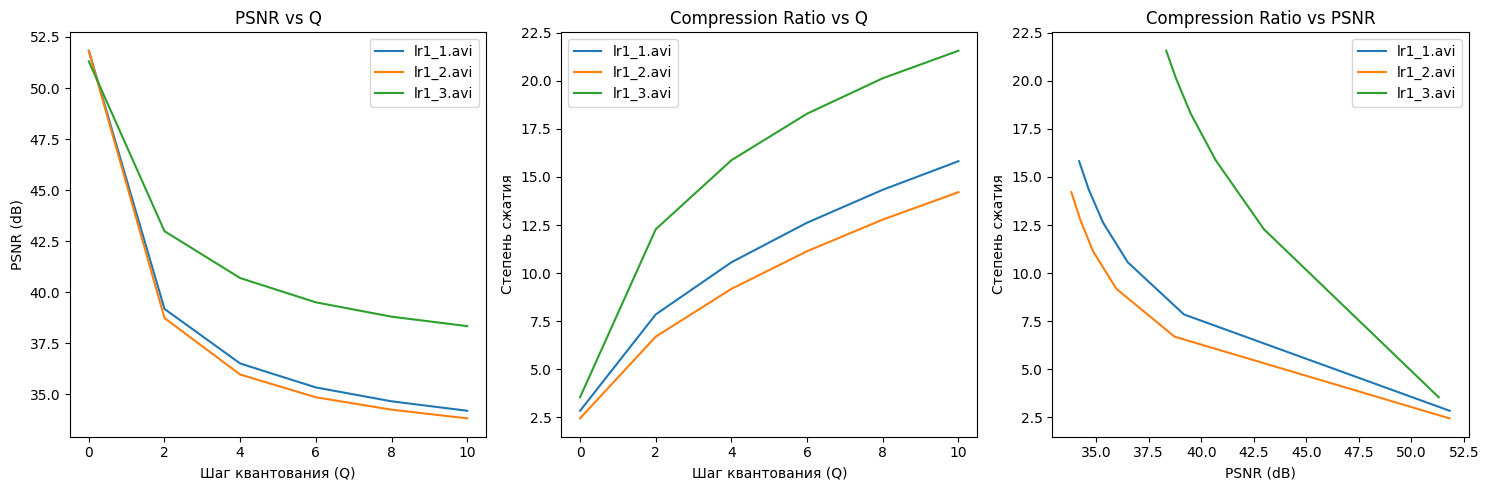

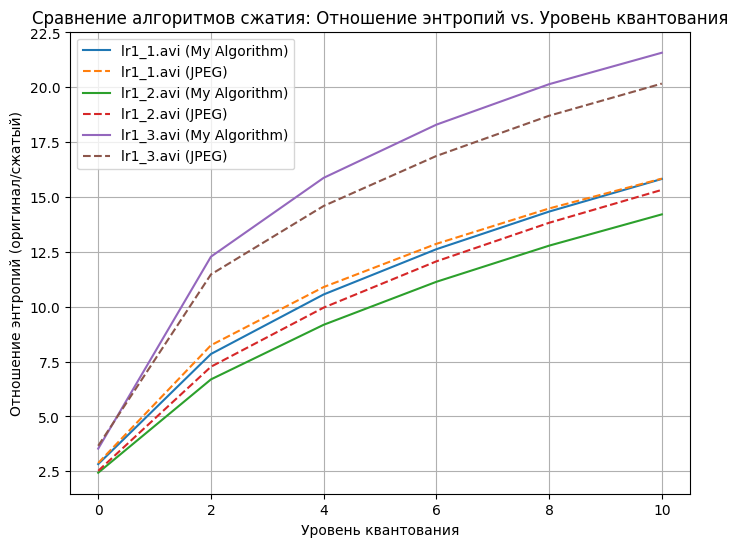

In [5]:
multiple_video_main()